<a href="https://colab.research.google.com/github/AI-competition-3to1/unmasking-converter/blob/main/kaggle_mask_detec.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kxsunmee","key":"c32b620fc69c4d1cbc2a78fe12311581"}'}

In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
! kaggle datasets download -d andrewmvd/face-mask-detection

 99% 394M/398M [00:04<00:00, 134MB/s]
100% 398M/398M [00:04<00:00, 103MB/s]


In [5]:
!unzip -qq "/content/face-mask-detection.zip" -d "/content/mask"

In [6]:
import numpy as np
import pandas as pd 
from bs4 import BeautifulSoup
import torchvision
from torchvision import transforms, datasets, models
import torch
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
import matplotlib.patches as patches
import os

In [7]:
def generate_box(obj):
    
    xmin = int(obj.find('xmin').text)
    ymin = int(obj.find('ymin').text)
    xmax = int(obj.find('xmax').text)
    ymax = int(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(image_id, file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, 'xml')
        objects = soup.find_all('object')

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([image_id])
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = img_id
        
        return target

In [8]:
imgs = list(sorted(os.listdir("/content/mask/images/")))

In [9]:
labels = list(sorted(os.listdir("/content/mask/annotations/")))

In [10]:
class MaskDataset(object):
    def __init__(self, transforms):
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir("/content/mask/images/")))

    def __getitem__(self, idx):
        # load images ad masks
        file_image = 'maksssksksss'+ str(idx) + '.png'
        file_label = 'maksssksksss'+ str(idx) + '.xml'
        img_path = os.path.join("/content/mask/images/", file_image)
        label_path = os.path.join("/content/mask/annotations/", file_label)
        img = Image.open(img_path).convert("RGB")
        #Generate Label
        target = generate_target(idx, label_path)
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [11]:
data_transform = transforms.Compose([transforms.ToTensor(), ])

In [12]:
def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset(data_transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)

In [13]:
torch.cuda.is_available()

True

In [14]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [15]:
model = get_model_instance_segmentation(3)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


In [16]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
for imgs, annotations in data_loader:
    imgs = list(img.to(device) for img in imgs)
    annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
    print(annotations)
    break

[{'boxes': tensor([[ 79., 105., 109., 142.],
        [185., 100., 226., 144.],
        [325.,  90., 360., 141.]], device='cuda:0'), 'labels': tensor([0, 1, 0], device='cuda:0'), 'image_id': tensor([0], device='cuda:0')}, {'boxes': tensor([[321.,  34., 354.,  69.],
        [224.,  38., 261.,  73.],
        [299.,  58., 315.,  81.],
        [143.,  74., 174., 115.],
        [ 74.,  69.,  95.,  99.],
        [191.,  67., 221.,  93.],
        [ 21.,  73.,  44.,  93.],
        [369.,  70., 398.,  99.],
        [ 83.,  56., 111.,  89.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0], device='cuda:0'), 'image_id': tensor([1], device='cuda:0')}, {'boxes': tensor([[ 68.,  42., 105.,  69.],
        [154.,  47., 178.,  74.],
        [238.,  34., 262.,  69.],
        [333.,  31., 366.,  65.]], device='cuda:0'), 'labels': tensor([1, 1, 1, 2], device='cuda:0'), 'image_id': tensor([2], device='cuda:0')}, {'boxes': tensor([[ 52.,  53.,  73.,  76.],
        [ 72.,  53.,  92.,  75.],
  

In [17]:
num_epochs = 25
model.to(device)
    
# parameters
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

for epoch in range(num_epochs):
    model.train()
    i = 0    
    epoch_loss = 0
    for imgs, annotations in data_loader:
        i += 1
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model([imgs[0]], [annotations[0]])
        losses = sum(loss for loss in loss_dict.values())        

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
#         print(f'Iteration: {i}/{len_dataloader}, Loss: {losses}')
        epoch_loss += losses
    print(epoch_loss)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


tensor(87.5802, device='cuda:0', grad_fn=<AddBackward0>)
tensor(59.2988, device='cuda:0', grad_fn=<AddBackward0>)
tensor(53.9296, device='cuda:0', grad_fn=<AddBackward0>)
tensor(46.3768, device='cuda:0', grad_fn=<AddBackward0>)
tensor(39.7362, device='cuda:0', grad_fn=<AddBackward0>)
tensor(35.7997, device='cuda:0', grad_fn=<AddBackward0>)
tensor(32.6473, device='cuda:0', grad_fn=<AddBackward0>)
tensor(31.9719, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.7998, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.2516, device='cuda:0', grad_fn=<AddBackward0>)
tensor(29.3520, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.0876, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.5264, device='cuda:0', grad_fn=<AddBackward0>)
tensor(25.9195, device='cuda:0', grad_fn=<AddBackward0>)
tensor(24.4181, device='cuda:0', grad_fn=<AddBackward0>)
tensor(26.1224, device='cuda:0', grad_fn=<AddBackward0>)
tensor(22.7390, device='cuda:0', grad_fn=<AddBackward0>)
tensor(18.8333, device='cuda:0'

In [18]:
for imgs, annotations in data_loader:
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        break

In [19]:
model.eval()
preds = model(imgs)
preds

[{'boxes': tensor([[185.7256,  98.7924, 225.2450, 145.2823]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1], device='cuda:0'),
  'scores': tensor([0.9935], device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[317.6110,  31.8591, 351.7716,  71.4384],
          [144.7896,  72.6850, 171.6848, 114.7748],
          [224.2669,  34.2030, 258.7868,  75.8037],
          [192.2223,  64.0339, 215.0971,  94.5684],
          [ 21.3488,  70.1054,  41.9817,  93.6032],
          [298.7985,  57.1709, 312.7835,  82.2887],
          [366.6517,  68.3829, 393.5770,  97.7025],
          [368.4754,  68.5397, 394.2472,  95.9174]], device='cuda:0',
         grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 2], device='cuda:0'),
  'scores': tensor([0.9943, 0.9922, 0.9886, 0.9862, 0.9773, 0.9605, 0.7903, 0.0680],
         device='cuda:0', grad_fn=<IndexBackward>)},
 {'boxes': tensor([[ 71.1706,  40.6814,  99.6032,  71.0121],
          [155.6033,  47.0731, 

In [21]:
def plot_image(img_tensor, annotation, block=True):
  fig,ax = plt.subplots(1)
  img = img_tensor.cpu().data
  # Display the image
  ax.imshow( np.array( img.permute(1, 2, 0) ) )

  for box, label in zip( annotation["boxes"], annotation["labels"] ):
    print("label",label)
    print("box",box)
    xmin, ymin, xmax, ymax = box
    # Create a Rectangle patch
    if label==1:
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='b',facecolor='none')
    else:
      rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
    # Add the patch to the Axes 
    ax.add_patch(rect)
    ax.axis("off")
  plt.show(block=block)

Prediction
label tensor(1, device='cuda:0')
box tensor([185.7256,  98.7924, 225.2450, 145.2823], device='cuda:0',
       grad_fn=<UnbindBackward>)


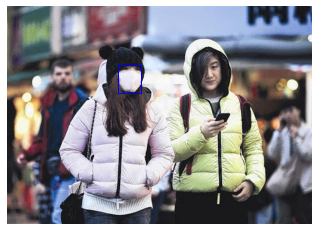

In [34]:
print("Prediction")
plot_image(imgs[0], preds[0])

Target
label tensor(0, device='cuda:0')
box tensor([ 79., 105., 109., 142.], device='cuda:0')
label tensor(1, device='cuda:0')
box tensor([185., 100., 226., 144.], device='cuda:0')
label tensor(0, device='cuda:0')
box tensor([325.,  90., 360., 141.], device='cuda:0')


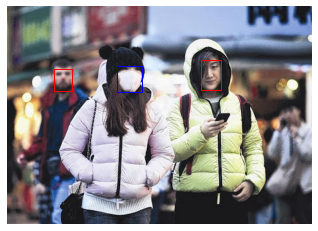

In [35]:
print("Target")
plot_image(imgs[0], annotations[0])